In [22]:
import pandas as pd

df = pd.read_excel("NQ_ES_SMT_Data.xlsx")

def detect_smt(df):
    signals = []

    prev_nq_bull_high = None
    prev_es_bull_high = None
    prev_nq_bear_low  = None
    prev_es_bear_low  = None

    prev_nq_bull_idx = None
    prev_es_bull_idx = None
    prev_nq_bear_idx = None
    prev_es_bear_idx = None

    for i in range(1, len(df)):
        nq_bull = df['nq_close'].iloc[i] > df['nq_open'].iloc[i]
        es_bull = df['es_close'].iloc[i] > df['es_open'].iloc[i]

        nq_bear = df['nq_close'].iloc[i] < df['nq_open'].iloc[i]
        es_bear = df['es_close'].iloc[i] < df['es_open'].iloc[i]

        nq_higher_high = nq_bull and (prev_nq_bull_high is not None) and (df['nq_high'].iloc[i] > prev_nq_bull_high)
        es_higher_high = es_bull and (prev_es_bull_high is not None) and (df['es_high'].iloc[i] > prev_es_bull_high)

        nq_lower_low = nq_bear and (prev_nq_bear_low is not None) and (df['nq_low'].iloc[i] < prev_nq_bear_low)
        es_lower_low = es_bear and (prev_es_bear_low is not None) and (df['es_low'].iloc[i] < prev_es_bear_low)

        if (
            nq_higher_high and not es_higher_high
            and nq_bull and es_bull
            and (prev_nq_bull_idx is not None) and (prev_es_bull_idx is not None)
            and (prev_nq_bull_idx == prev_es_bull_idx)
        ):
            signals.append(("bearish SMT", df['timestamp'].iloc[i]))

        if (
            es_lower_low and not nq_lower_low
            and es_bear and nq_bear
            and (prev_es_bear_idx is not None) and (prev_nq_bear_idx is not None)
            and (prev_es_bear_idx == prev_nq_bear_idx)
        ):
            signals.append(("bullish SMT", df['timestamp'].iloc[i]))

        if nq_bull:
            prev_nq_bull_high = df['nq_high'].iloc[i]
            prev_nq_bull_idx = i
        if es_bull:
            prev_es_bull_high = df['es_high'].iloc[i]
            prev_es_bull_idx = i
        if nq_bear:
            prev_nq_bear_low = df['nq_low'].iloc[i]
            prev_nq_bear_idx = i
        if es_bear:
            prev_es_bear_low = df['es_low'].iloc[i]
            prev_es_bear_idx = i

    return signals

signals = detect_smt(df)
signals


[('bearish SMT', Timestamp('2024-05-15 11:00:00')),
 ('bullish SMT', Timestamp('2024-05-15 15:00:00')),
 ('bearish SMT', Timestamp('2024-05-15 17:30:00')),
 ('bearish SMT', Timestamp('2024-05-16 01:00:00'))]

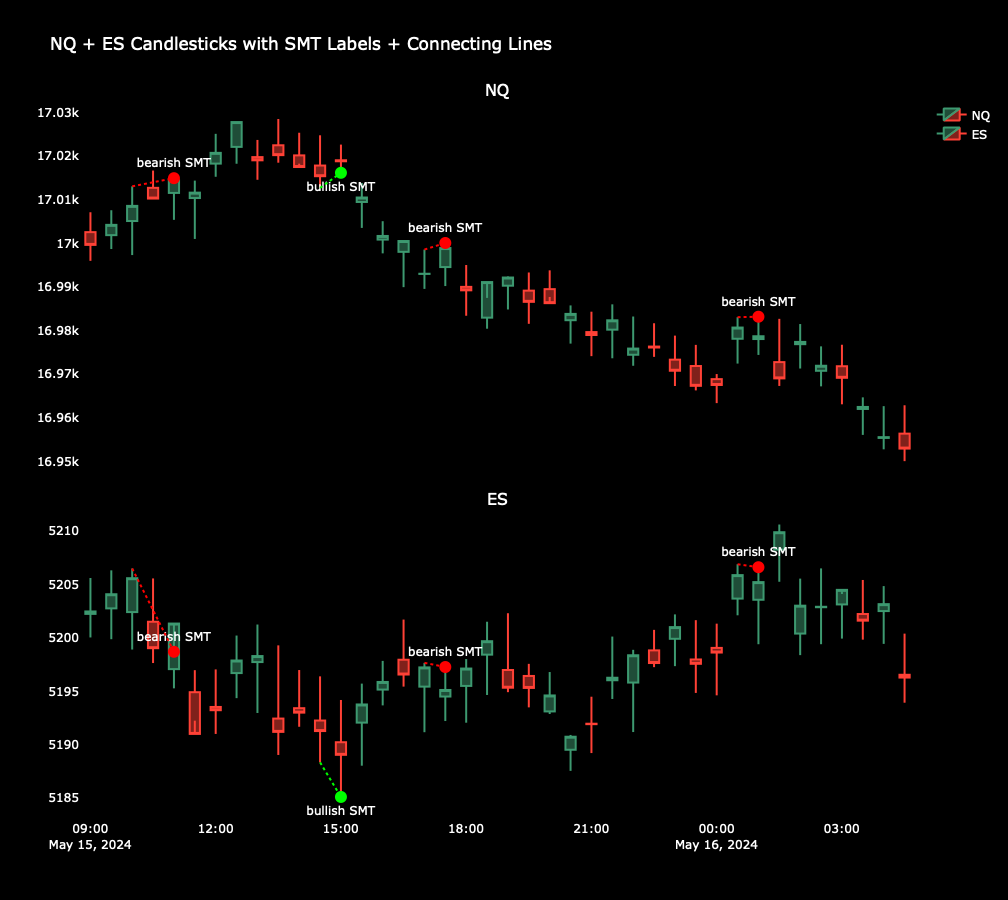

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.04,
    row_heights=[0.55, 0.45],
    subplot_titles=("NQ", "ES")
)

fig.add_trace(go.Candlestick(
    x=df['timestamp'],
    open=df['nq_open'],
    high=df['nq_high'],
    low=df['nq_low'],
    close=df['nq_close'],
    name="NQ"
), row=1, col=1)

fig.add_trace(go.Candlestick(
    x=df['timestamp'],
    open=df['es_open'],
    high=df['es_high'],
    low=df['es_low'],
    close=df['es_close'],
    name="ES"
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=df['timestamp'].iloc[bearish_idx],
    y=df['nq_high'].iloc[bearish_idx],
    mode="markers+text",
    text=["bearish SMT"] * len(bearish_idx),
    textposition="top center",
    marker=dict(color="red", size=12),
    showlegend=False
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df['timestamp'].iloc[bullish_idx],
    y=df['nq_low'].iloc[bullish_idx],
    mode="markers+text",
    text=["bullish SMT"] * len(bullish_idx),
    textposition="bottom center",
    marker=dict(color="lime", size=12),
    showlegend=False
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df['timestamp'].iloc[bearish_idx],
    y=df['es_high'].iloc[bearish_idx],
    mode="markers+text",
    text=["bearish SMT"] * len(bearish_idx),
    textposition="top center",
    marker=dict(color="red", size=12),
    showlegend=False
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=df['timestamp'].iloc[bullish_idx],
    y=df['es_low'].iloc[bullish_idx],
    mode="markers+text",
    text=["bullish SMT"] * len(bullish_idx),
    textposition="bottom center",
    marker=dict(color="lime", size=12),
    showlegend=False
), row=2, col=1)

for smt_type, pidx, cidx in smt_pairs:
    if smt_type == "bearish SMT":
        nq_y0, nq_y1 = df['nq_high'].iloc[pidx], df['nq_high'].iloc[cidx]
        es_y0, es_y1 = df['es_high'].iloc[pidx], df['es_high'].iloc[cidx]
        line_color = "red"
    else:
        nq_y0, nq_y1 = df['nq_low'].iloc[pidx], df['nq_low'].iloc[cidx]
        es_y0, es_y1 = df['es_low'].iloc[pidx], df['es_low'].iloc[cidx]
        line_color = "lime"

    fig.add_trace(go.Scatter(
        x=[df['timestamp'].iloc[pidx], df['timestamp'].iloc[cidx]],
        y=[nq_y0, nq_y1],
        mode="lines",
        line=dict(color=line_color, width=2, dash="dot"),
        showlegend=False
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[df['timestamp'].iloc[pidx], df['timestamp'].iloc[cidx]],
        y=[es_y0, es_y1],
        mode="lines",
        line=dict(color=line_color, width=2, dash="dot"),
        showlegend=False
    ), row=2, col=1)

fig.update_layout(
    title="NQ + ES Candlesticks with SMT Labels + Connecting Lines",
    width=1200,
    height=900,
    plot_bgcolor="black",
    paper_bgcolor="black",
    font=dict(color="white"),
    xaxis_rangeslider_visible=False
)

fig.update_xaxes(showgrid=False, rangeslider_visible=False)
fig.update_yaxes(showgrid=False)

fig.show()
